In [94]:
#from google.colab import files
#uploaded = files.upload()

In [1]:
import zipfile
import os

#dataset_path = "/content/Intel Image Classification.zip"
#extract_path = "/content/dataset"

#with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_path)

#print("Dataset extracted successfully!")


In [3]:
# Count classses

dataset_root = r"C:\Users\tim20\Desktop\Study\University\6 semester\DLCV\Project_Hrynchuk\Intel_Image_Classification"

train_dir = os.path.join(dataset_root, "seg_train", "seg_train")
test_dir = os.path.join(dataset_root, "seg_test", "seg_test")
pred_dir = r'C:\Users\tim20\Desktop\Study\University\6 semester\DLCV\Project_Hrynchuk\Intel_Image_Classification\seg_pred\seg_pred'

print("Train Classes:", os.listdir(train_dir))
print("Test Classes:", os.listdir(test_dir))

for folder in os.listdir(train_dir):
    num_images = len(os.listdir(os.path.join(train_dir, folder)))
    print(f"Class '{folder}': {num_images} train images")


Train Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Test Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Class 'buildings': 2191 train images
Class 'forest': 2271 train images
Class 'glacier': 2404 train images
Class 'mountain': 2512 train images
Class 'sea': 2274 train images
Class 'street': 2382 train images


In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

image_size = (150, 150)
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load training dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes

print(f"Train split: {len(train_dataset)} images")
print(f"Test set: {len(test_dataset)} images")


Train split: 14034 images
Test set: 3000 images


In [7]:
from PIL import Image
import torchvision.transforms as transforms

class ImageFolderNoClass(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, filename) for filename in os.listdir(root_dir)
                            if os.path.isfile(os.path.join(root_dir, filename))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

pred_dataset = ImageFolderNoClass(root_dir=pred_dir, transform=transform)
pred_loader = DataLoader(pred_dataset, batch_size=batch_size, shuffle=False)

print(f"Prediction set: {len(pred_dataset)} images")


Prediction set: 7301 images


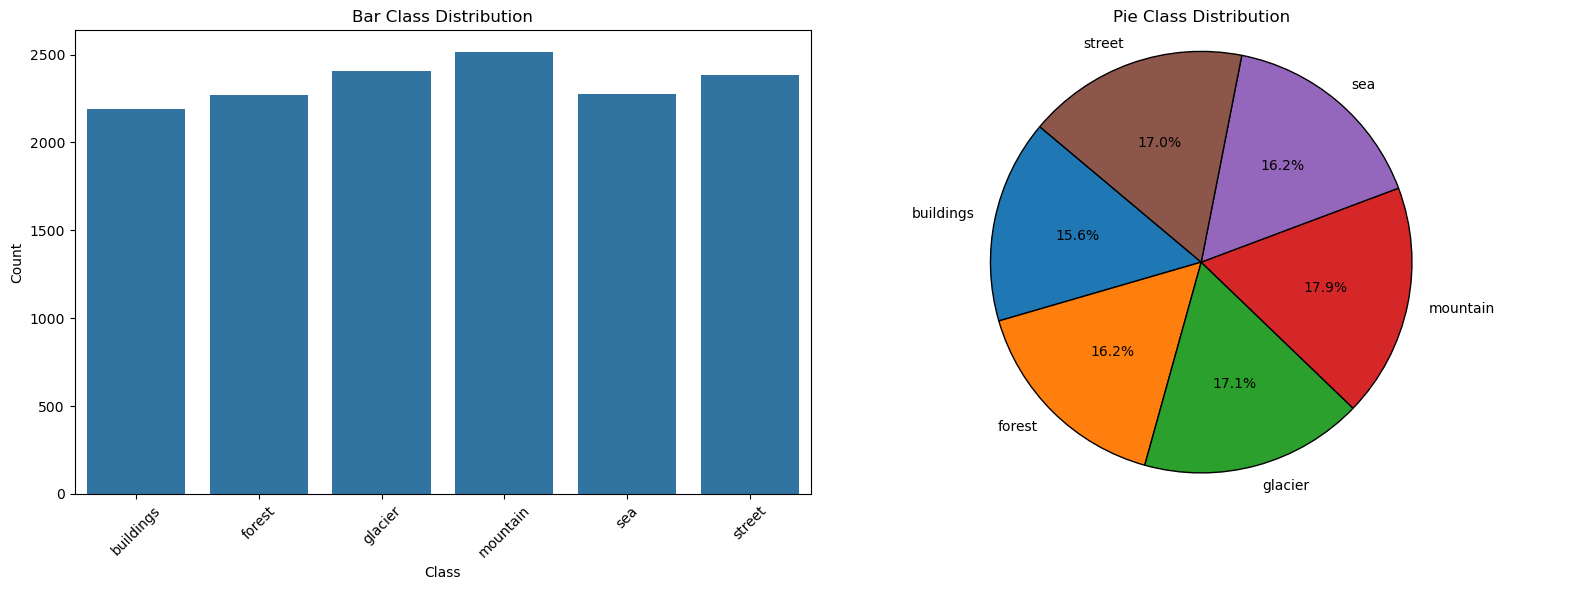

In [9]:
# Chart visualization

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

class_counts = Counter([class_names[label] for _, label in train_dataset])
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), ax=axs[0])
axs[0].set_title("Bar Class Distribution")
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Count")
axs[0].tick_params(axis='x', rotation=45)

# Pie chart
axs[1].pie(
    list(class_counts.values()),
    labels=list(class_counts.keys()),
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
axs[1].set_title("Pie Class Distribution")
axs[1].axis('equal')

plt.tight_layout()
plt.show()

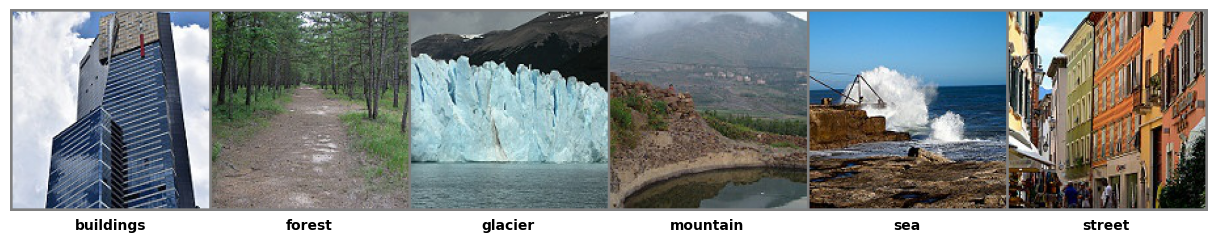

In [11]:
# Visualization

import torchvision
import numpy as np

def imshow_with_labels(images, labels, class_names):
    images = images.cpu()
    images = images / 2 + 0.5
    npimg = images.numpy()

    fig, ax = plt.subplots(figsize=(12, 3))
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis("off")

    num_images = len(labels)
    img_width = npimg.shape[2]
    step = img_width // num_images

    for i, label in enumerate(labels):
        class_name = class_names[label]
        x_pos = step * i + step // 2
        ax.text(x_pos, npimg.shape[1] + 5, class_name, ha='center', va='top',
                fontsize=10, color='black', fontweight="bold")

    plt.tight_layout(pad=0.1)
    plt.show()

def get_one_image_per_class(loader, num_classes):
    class_seen = [False] * num_classes
    images_per_class = [None] * num_classes
    labels_per_class = [None] * num_classes

    for images, labels in loader:
        for img, lbl in zip(images, labels):
            lbl = lbl.item()
            if not class_seen[lbl]:
                class_seen[lbl] = True
                images_per_class[lbl] = img
                labels_per_class[lbl] = lbl
            if all(class_seen):
                return torch.stack(images_per_class), torch.tensor(labels_per_class)
    raise RuntimeError("Not enough classes found in the data.")

images, labels = get_one_image_per_class(test_loader, num_classes=6)
imshow_with_labels(torchvision.utils.make_grid(images, padding=2), labels, test_loader.dataset.classes)

**Висновок:**

Запропонований датасет збалансований і організований, всі класи мають схожу кількість зображень, вибірка поділяється 1 до 5, як тестові до навчальний данних, що є хорошим співвідношенням.

Також я реалізував попередню обробку зображень, включаючи перетворення до тензорів, нормалізацію, а також аугментацію для підвищення загальної якості навчання. Крім того, розділив навчальну вибірку на навчальну та валідаційну підмножини у співвідношенні 80:20, що дозволяє більш точно оцінювати продуктивність моделі під час тренування.


In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [16]:
# GPU

#print(torch.cuda.get_device_properties())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [18]:
class CNN(nn.Module):
    def __init__(self, num_classes=6):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 18 * 18, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN(num_classes=len(class_names)).to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=41472, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
)


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

num_epochs = 30

train_losses, train_accs, train_recs, train_precs, train_f1s = [], [], [], [], []
test_losses, test_accs, test_recs, test_precs, test_f1s = [], [], [], [], []

print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Acc':>6} | {'Rec':>6} | {'Prec':>6} | {'F1':>6} || "
          f"{'Val Loss':>9} | {'Val Acc':>7} | {'Val Rec':>7} | {'Val Prec':>9} | {'Val F1':>8}")

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    all_preds, all_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_train_loss = total_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    train_acc = accuracy_score(all_labels, all_preds)
    train_prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    train_accs.append(train_acc)
    train_recs.append(train_rec)
    train_precs.append(train_prec)
    train_f1s.append(train_f1)

    # ----- Validation -----
    model.eval()
    total_test_loss = 0
    test_preds, test_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    epoch_test_loss = total_test_loss / len(test_loader)
    test_losses.append(epoch_test_loss)

    test_acc = accuracy_score(test_labels, test_preds)
    test_prec = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
    test_rec = recall_score(test_labels, test_preds, average='weighted', zero_division=0)
    test_f1 = f1_score(test_labels, test_preds, average='weighted', zero_division=0)
    
    test_accs.append(test_acc)
    test_recs.append(test_rec)
    test_precs.append(test_prec)
    test_f1s.append(test_f1)

    print(f"{epoch+1:5d} | {epoch_train_loss:10.4f} | {train_acc:6.4f} | {train_rec:6.4f} | {train_prec:6.4f} | {train_f1:6.4f} || "
      f"{epoch_test_loss:9.4f} | {test_acc:7.4f} | {test_rec:7.4f} | {test_prec:9.4f} | {test_f1:8.4f}")

Epoch | Train Loss |    Acc |    Rec |   Prec |     F1 ||  Val Loss | Val Acc | Val Rec |  Val Prec |   Val F1
    1 |     0.9933 | 0.6107 | 0.6107 | 0.6057 | 0.6064 ||    0.7505 |  0.7293 |  0.7293 |    0.7390 |   0.7287
    2 |     0.6796 | 0.7490 | 0.7490 | 0.7488 | 0.7489 ||    0.5417 |  0.8067 |  0.8067 |    0.8141 |   0.8061
    3 |     0.5451 | 0.8054 | 0.8054 | 0.8052 | 0.8053 ||    0.5003 |  0.8257 |  0.8257 |    0.8286 |   0.8253
    4 |     0.4793 | 0.8294 | 0.8294 | 0.8294 | 0.8293 ||    0.4784 |  0.8393 |  0.8393 |    0.8439 |   0.8402
    5 |     0.4189 | 0.8499 | 0.8499 | 0.8499 | 0.8499 ||    0.5034 |  0.8263 |  0.8263 |    0.8346 |   0.8276
    6 |     0.3904 | 0.8610 | 0.8610 | 0.8608 | 0.8609 ||    0.4557 |  0.8490 |  0.8490 |    0.8526 |   0.8495
    7 |     0.3495 | 0.8743 | 0.8743 | 0.8743 | 0.8743 ||    0.4706 |  0.8460 |  0.8460 |    0.8483 |   0.8459
    8 |     0.3020 | 0.8938 | 0.8938 | 0.8938 | 0.8937 ||    0.4853 |  0.8483 |  0.8483 |    0.8513 |   0.8489
 

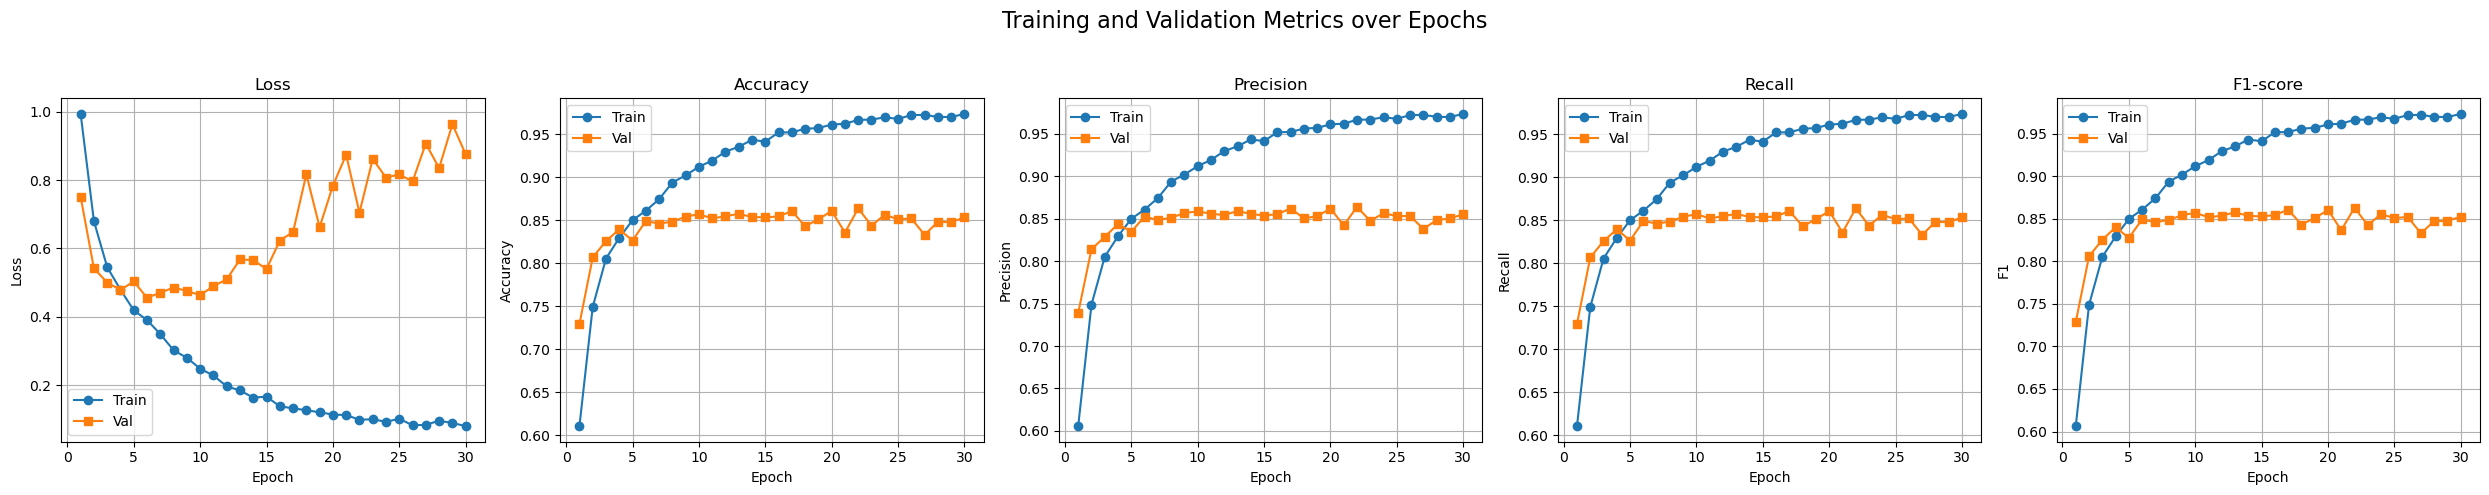

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

fig, axs = plt.subplots(1, 5, figsize=(25, 5), sharex=True)
fig.suptitle("Training and Validation Metrics over Epochs", fontsize=16)

# Loss
axs[0].plot(epochs, train_losses, label='Train', marker='o')
axs[0].plot(epochs, test_losses, label='Val', marker='s')
axs[0].set_title("Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(True)

# Accuracy
axs[1].plot(epochs, train_accs, label='Train', marker='o')
axs[1].plot(epochs, test_accs, label='Val', marker='s')
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid(True)

# Precision
axs[2].plot(epochs, train_precs, label='Train', marker='o')
axs[2].plot(epochs, test_precs, label='Val', marker='s')
axs[2].set_title("Precision")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Precision")
axs[2].legend()
axs[2].grid(True)

# Recall
axs[3].plot(epochs, train_recs, label='Train', marker='o')
axs[3].plot(epochs, test_recs, label='Val', marker='s')
axs[3].set_title("Recall")
axs[3].set_xlabel("Epoch")
axs[3].set_ylabel("Recall")
axs[3].legend()
axs[3].grid(True)

# F1
axs[4].plot(epochs, train_f1s, label='Train', marker='o')
axs[4].plot(epochs, test_f1s, label='Val', marker='s')
axs[4].set_title("F1-score")
axs[4].set_xlabel("Epoch")
axs[4].set_ylabel("F1")
axs[4].legend()
axs[4].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



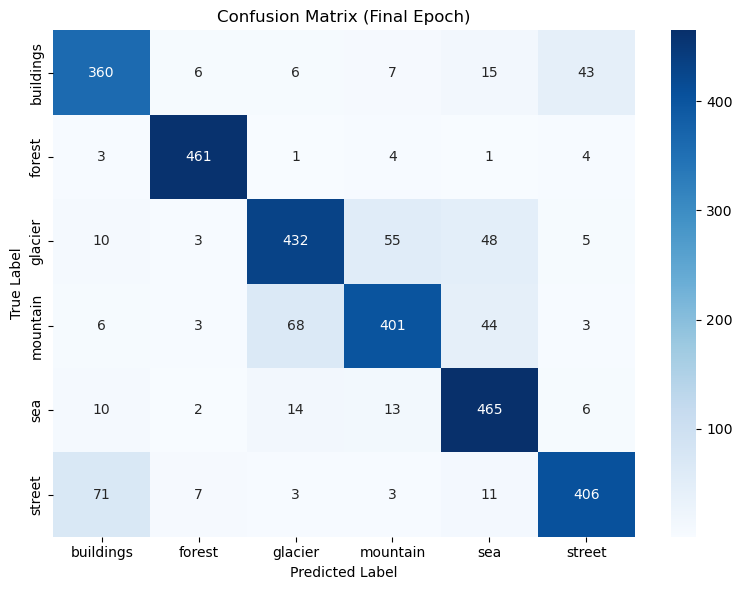

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set model to eval mode
model.eval()

# Collect predictions on test set
all_preds, all_targets = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds, labels=list(range(len(class_names))))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Final Epoch)")
plt.tight_layout()
plt.show()


In [29]:
class FlexibleCNN(nn.Module):
        def __init__(self, conv_layers=3, hidden_neurons=128, num_classes=6, input_size=(3, 150, 150)):
            super(FlexibleCNN, self).__init__()
            layers = []
            in_channels = 3
            out_channels = 32

            for i in range(conv_layers):
                layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
                layers.append(nn.ReLU())
                layers.append(nn.MaxPool2d(2, 2))
                in_channels = out_channels
                out_channels *= 2

            self.conv = nn.Sequential(*layers)

            with torch.no_grad():
                temp = torch.zeros(1, *input_size)
                temp = self.conv(temp)
                self.flattened_size = temp.view(1, -1).shape[1]
            
            self.flatten = nn.Flatten()
            self.fc1 = nn.Linear(self.flattened_size, hidden_neurons)
            self.dropout = nn.Dropout(0.5)
            self.fc2 = nn.Linear(hidden_neurons, num_classes)

        def forward(self, x):
            x = self.conv(x)
            x = self.flatten(x)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x

In [31]:
def train_with_hparams(conv_layers=3, hidden_neurons=128, learning_rate=0.001):

    model = FlexibleCNN(conv_layers, hidden_neurons, len(class_names)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_loss = 0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_loss = train_loss / len(train_loader)
    print(f"[conv_layers={conv_layers}, hidden_neurons={hidden_neurons}, lr={learning_rate}] -> Train Loss: {avg_loss:.4f}")
    return avg_loss

In [33]:
learning_rates = [0.01, 0.001, 0.0001]
hidden_neuron_options = [64, 128, 256]
conv_layer_options = [2, 3, 4]

results = []
for lr in learning_rates:
    for hn in hidden_neuron_options:
        for cl in conv_layer_options:
            loss = train_with_hparams(conv_layers=cl, hidden_neurons=hn, learning_rate=lr)
            results.append((cl, hn, lr, loss))

[conv_layers=2, hidden_neurons=64, lr=0.01] -> Train Loss: 1.9607
[conv_layers=3, hidden_neurons=64, lr=0.01] -> Train Loss: 1.8994
[conv_layers=4, hidden_neurons=64, lr=0.01] -> Train Loss: 1.9421
[conv_layers=2, hidden_neurons=128, lr=0.01] -> Train Loss: 2.2034
[conv_layers=3, hidden_neurons=128, lr=0.01] -> Train Loss: 1.4006
[conv_layers=4, hidden_neurons=128, lr=0.01] -> Train Loss: 1.9989
[conv_layers=2, hidden_neurons=256, lr=0.01] -> Train Loss: 2.0669
[conv_layers=3, hidden_neurons=256, lr=0.01] -> Train Loss: 1.5886
[conv_layers=4, hidden_neurons=256, lr=0.01] -> Train Loss: 2.0451
[conv_layers=2, hidden_neurons=64, lr=0.001] -> Train Loss: 1.0784
[conv_layers=3, hidden_neurons=64, lr=0.001] -> Train Loss: 1.0755
[conv_layers=4, hidden_neurons=64, lr=0.001] -> Train Loss: 1.1004
[conv_layers=2, hidden_neurons=128, lr=0.001] -> Train Loss: 1.1497
[conv_layers=3, hidden_neurons=128, lr=0.001] -> Train Loss: 1.0447
[conv_layers=4, hidden_neurons=128, lr=0.001] -> Train Loss: 1.

In [35]:
#!pip install optuna --quiet
import optuna

In [41]:
def objective(trial):
    conv_layers = trial.suggest_int("conv_layers", 2, 3)
    hidden_neurons = trial.suggest_categorical("hidden_neurons", [64, 128, 256])
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    model = FlexibleCNN(conv_layers, hidden_neurons, len(class_names)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    return accuracy_score(targets, preds)

In [43]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

best_params = study.best_params
print("Training with best params:", best_params)

final_model = train_with_hparams(
    conv_layers=best_params["conv_layers"],
    hidden_neurons=best_params["hidden_neurons"],
    learning_rate=best_params["lr"]
)

[I 2025-04-17 14:31:40,311] A new study created in memory with name: no-name-84bc9774-3ccc-4af3-a717-9df223a43540
[I 2025-04-17 14:31:59,775] Trial 0 finished with value: 0.741 and parameters: {'conv_layers': 2, 'hidden_neurons': 128, 'lr': 0.00045590711226356354}. Best is trial 0 with value: 0.741.
[I 2025-04-17 14:32:19,541] Trial 1 finished with value: 0.734 and parameters: {'conv_layers': 2, 'hidden_neurons': 256, 'lr': 0.0010494488629169579}. Best is trial 0 with value: 0.741.
[I 2025-04-17 14:32:38,457] Trial 2 finished with value: 0.7296666666666667 and parameters: {'conv_layers': 2, 'hidden_neurons': 128, 'lr': 0.0004629489452844095}. Best is trial 0 with value: 0.741.
[I 2025-04-17 14:32:57,279] Trial 3 finished with value: 0.7053333333333334 and parameters: {'conv_layers': 2, 'hidden_neurons': 64, 'lr': 0.0005258838983081347}. Best is trial 0 with value: 0.741.
[I 2025-04-17 14:33:16,847] Trial 4 finished with value: 0.7103333333333334 and parameters: {'conv_layers': 3, 'hidd

Training with best params: {'conv_layers': 2, 'hidden_neurons': 128, 'lr': 0.00045590711226356354}
[conv_layers=2, hidden_neurons=128, lr=0.00045590711226356354] -> Train Loss: 1.0210


In [66]:
class CNNWithBestValues(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNWithBestValues, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv = nn.Sequential(
            self.conv1, nn.ReLU(), self.pool1,
            self.conv2, nn.ReLU(), self.pool2
        )
        
        with torch.no_grad():
            temp = torch.zeros(1, 3, 150, 150)
            temp = self.conv(temp)
            self.flattened_size = temp.view(1, -1).shape[1]
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNNWithBestValues(num_classes=len(class_names)).to(device)
print(model)

CNNWithBestValues(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=87616, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004559)

In [70]:
num_epochs = 30

train_losses, train_accs, train_recs, train_precs, train_f1s = [], [], [], [], []
test_losses, test_accs, test_recs, test_precs, test_f1s = [], [], [], [], []

print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Acc':>6} | {'Rec':>6} | {'Prec':>6} | {'F1':>6} || "
          f"{'Val Loss':>9} | {'Val Acc':>7} | {'Val Rec':>7} | {'Val Prec':>9} | {'Val F1':>8}")

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    all_preds, all_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_train_loss = total_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    train_acc = accuracy_score(all_labels, all_preds)
    train_prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    train_accs.append(train_acc)
    train_recs.append(train_rec)
    train_precs.append(train_prec)
    train_f1s.append(train_f1)

    # ----- Validation -----
    model.eval()
    total_test_loss = 0
    test_preds, test_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    epoch_test_loss = total_test_loss / len(test_loader)
    test_losses.append(epoch_test_loss)

    test_acc = accuracy_score(test_labels, test_preds)
    test_prec = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
    test_rec = recall_score(test_labels, test_preds, average='weighted', zero_division=0)
    test_f1 = f1_score(test_labels, test_preds, average='weighted', zero_division=0)
    
    test_accs.append(test_acc)
    test_recs.append(test_rec)
    test_precs.append(test_prec)
    test_f1s.append(test_f1)

    print(f"{epoch+1:5d} | {epoch_train_loss:10.4f} | {train_acc:6.4f} | {train_rec:6.4f} | {train_prec:6.4f} | {train_f1:6.4f} || "
      f"{epoch_test_loss:9.4f} | {test_acc:7.4f} | {test_rec:7.4f} | {test_prec:9.4f} | {test_f1:8.4f}")

Epoch | Train Loss |    Acc |    Rec |   Prec |     F1 ||  Val Loss | Val Acc | Val Rec |  Val Prec |   Val F1
    1 |     1.0243 | 0.6169 | 0.6169 | 0.6145 | 0.6147 ||    0.7538 |  0.7253 |  0.7253 |    0.7461 |   0.7289
    2 |     0.7098 | 0.7446 | 0.7446 | 0.7448 | 0.7445 ||    0.6008 |  0.7807 |  0.7807 |    0.7924 |   0.7820
    3 |     0.5897 | 0.7924 | 0.7924 | 0.7924 | 0.7923 ||    0.5203 |  0.8167 |  0.8167 |    0.8211 |   0.8177
    4 |     0.5025 | 0.8226 | 0.8226 | 0.8227 | 0.8226 ||    0.4866 |  0.8303 |  0.8303 |    0.8303 |   0.8296
    5 |     0.4439 | 0.8469 | 0.8469 | 0.8468 | 0.8468 ||    0.4668 |  0.8333 |  0.8333 |    0.8347 |   0.8332
    6 |     0.3912 | 0.8646 | 0.8646 | 0.8645 | 0.8646 ||    0.4774 |  0.8380 |  0.8380 |    0.8386 |   0.8374
    7 |     0.3559 | 0.8782 | 0.8782 | 0.8782 | 0.8781 ||    0.5030 |  0.8337 |  0.8337 |    0.8369 |   0.8341
    8 |     0.3168 | 0.8884 | 0.8884 | 0.8883 | 0.8883 ||    0.4763 |  0.8390 |  0.8390 |    0.8438 |   0.8386
 

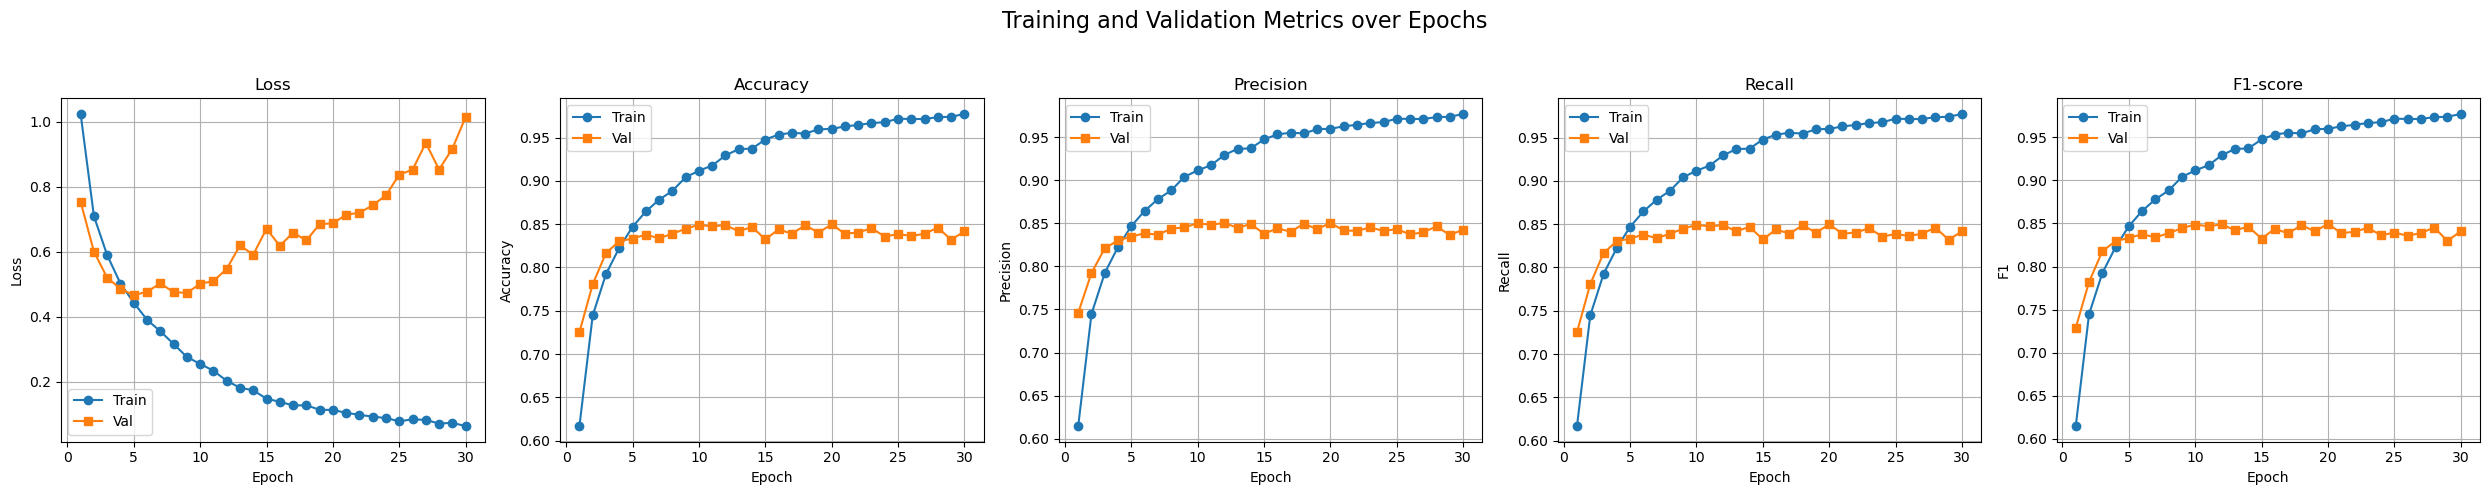

In [72]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

fig, axs = plt.subplots(1, 5, figsize=(25, 5), sharex=True)
fig.suptitle("Training and Validation Metrics over Epochs", fontsize=16)

# Loss
axs[0].plot(epochs, train_losses, label='Train', marker='o')
axs[0].plot(epochs, test_losses, label='Val', marker='s')
axs[0].set_title("Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(True)

# Accuracy
axs[1].plot(epochs, train_accs, label='Train', marker='o')
axs[1].plot(epochs, test_accs, label='Val', marker='s')
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid(True)

# Precision
axs[2].plot(epochs, train_precs, label='Train', marker='o')
axs[2].plot(epochs, test_precs, label='Val', marker='s')
axs[2].set_title("Precision")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Precision")
axs[2].legend()
axs[2].grid(True)

# Recall
axs[3].plot(epochs, train_recs, label='Train', marker='o')
axs[3].plot(epochs, test_recs, label='Val', marker='s')
axs[3].set_title("Recall")
axs[3].set_xlabel("Epoch")
axs[3].set_ylabel("Recall")
axs[3].legend()
axs[3].grid(True)

# F1
axs[4].plot(epochs, train_f1s, label='Train', marker='o')
axs[4].plot(epochs, test_f1s, label='Val', marker='s')
axs[4].set_title("F1-score")
axs[4].set_xlabel("Epoch")
axs[4].set_ylabel("F1")
axs[4].legend()
axs[4].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

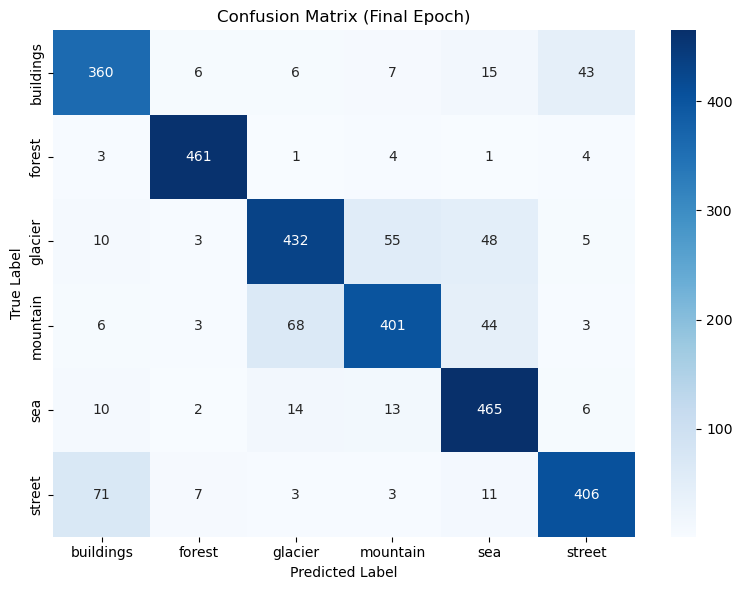

In [74]:
model.eval()

# Collect predictions on test set
all_preds, all_targets = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds, labels=list(range(len(class_names))))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Final Epoch)")
plt.tight_layout()
plt.show()


In [78]:
from torchvision import models

# ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [80]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)   

In [86]:
# Замороження всіх параметрів
for param in model.parameters():
    param.requires_grad = False

# Розморозити тільки останній FC шар
for param in model.fc.parameters():
    param.requires_grad = True

# Аугментації
train_transform_augmented = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_dataset_aug = datasets.ImageFolder(root=train_dir, transform=train_transform_augmented)
test_dataset_aug = datasets.ImageFolder(root=test_dir, transform=transform)

train_aug_loader = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
val_aug_loader = DataLoader(test_dataset_aug, batch_size=batch_size, shuffle=False)

# Оптимізатор та scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [90]:
# Донавчання
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, labels in train_aug_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_aug_loader):.4f}")

Epoch 1/5, Loss: 0.5016
Epoch 2/5, Loss: 0.3225
Epoch 3/5, Loss: 0.2949
Epoch 4/5, Loss: 0.2748
Epoch 5/5, Loss: 0.2747


Classification Report:
              precision    recall  f1-score   support

   buildings       0.88      0.94      0.91       437
      forest       0.99      0.99      0.99       474
     glacier       0.84      0.81      0.83       553
    mountain       0.85      0.81      0.83       525
         sea       0.90      0.97      0.93       510
      street       0.94      0.91      0.92       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



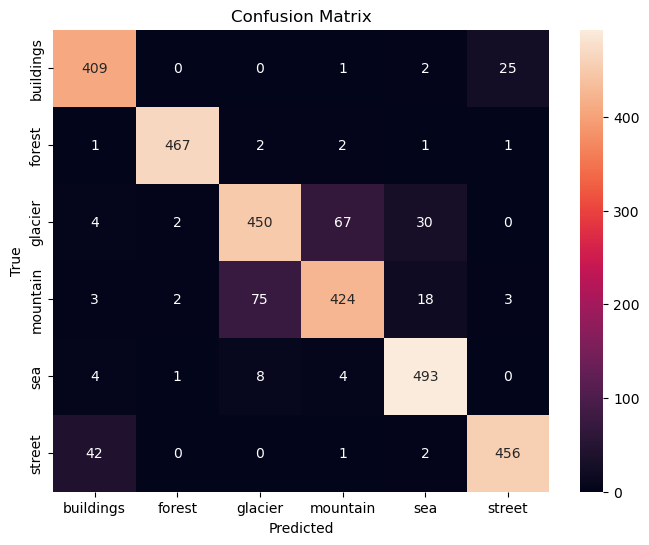

In [94]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in val_aug_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Метрики
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Матриця плутанини
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

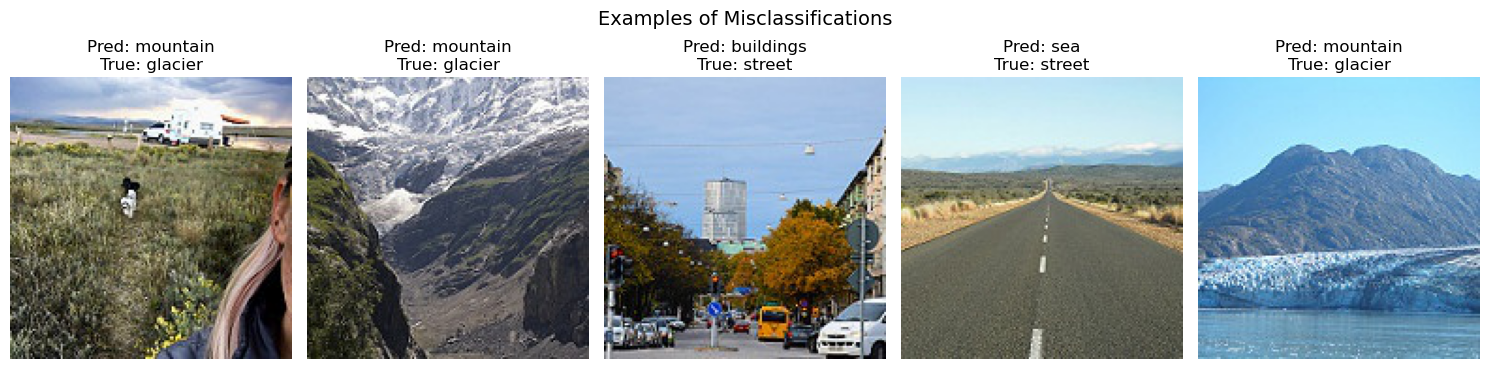

In [102]:
import random

misclassified = [(i, pred, true) for i, (pred, true) in enumerate(zip(y_pred, y_true)) if pred != true]
random.shuffle(misclassified)

# Plot a few of them
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for ax, (idx, pred, true) in zip(axes, misclassified[:5]):
    img, _ = test_dataset_aug[idx]
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0)) * 0.5 + 0.5

    ax.imshow(img)
    ax.set_title(f"Pred: {class_names[pred]}\nTrue: {class_names[true]}")
    ax.axis("off")

plt.suptitle("Examples of Misclassifications", fontsize=14)
plt.tight_layout()
plt.show()
    

In [89]:
# Збереження моделі
torch.save(base_model.state_dict(), "best_transfer_model.pth")
print("Model saved as best_transfer_model.pth")

Model saved as best_transfer_model.pth
